In [1]:
import pandas as pd
import numpy as np
import os #Interacts with the operating system, e.g. paths, mkdir
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # Allows ploting in a 3D graph

from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix,classification_report

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


In [2]:
file_path = r'C:/Users/crist/Documents/02.MSU_MsDataScience/2024.SPRING/04.CSIT598_03SP24_MACHINE-LEARNING/02.MACHINE_LEARNING_SP23/PowerPlantsintheU_Export_TableToExcel.xlsx'
df = pd.read_excel(file_path)

In [48]:
# Select columns to analyze
Scolumns = ['sector_nam','PrimSource','Install_MW','Total_MW','Longitude','Latitude']

label_encoder = LabelEncoder()

data_encoded = df[Scolumns].copy()

data_encoded['Sector_encoded'] = label_encoder.fit_transform(df[Scolumns].sector_nam)
data_encoded['PimSource_encoded'] = label_encoder.fit_transform(df[Scolumns].PrimSource)


# # One-hot encoding
# data_encoded = pd.get_dummies(df[Scolumns], columns = ['PrimSource'], dtype='int')

data_encoded = data_encoded[['Install_MW','Total_MW','Longitude','Latitude','PimSource_encoded','Sector_encoded']]
data_encoded       

,Install_MW,Total_MW,Longitude,Latitude,PimSource_encoded,Sector_encoded
0,2.3,2.3,-89.685000,45.178600,4,2
1,1.3,1.3,-87.758600,45.113600,4,2
2,91.0,79.0,-88.008600,44.540000,5,2
3,3.8,3.8,-88.067800,45.233300,4,2
4,2.6,2.6,-89.730600,45.441100,4,2
...,...,...,...,...,...,...
12003,3.0,3.0,-82.375953,35.380139,10,4
12004,3.0,3.0,-79.367698,36.009321,10,4
12005,5.0,5.0,-79.736312,35.273434,10,4
12006,1.4,1.4,-73.910480,42.876570,10,4


In [49]:
X = data_encoded.drop('Total_MW',axis=1)
y = data_encoded['Total_MW']
print("Shape of features (X):", X.shape)
print("Shape of target variable (y):", y.shape)

Shape of features (X): (12008, 5)
Shape of target variable (y): (12008,)


## Scale the data

In [50]:
scaler = MinMaxScaler()

# Fit the scaler to your training data and transform the features
X_scaled = scaler.fit_transform(X)

In [51]:
X_scaled

array([[2.93741830e-04, 7.70696422e-01, 5.10479777e-01, 3.63636364e-01,
        3.33333333e-01],
       [1.46870915e-04, 7.88796092e-01, 5.09261291e-01, 3.63636364e-01,
        3.33333333e-01],
       [1.33211920e-02, 7.86447194e-01, 4.98508620e-01, 4.54545455e-01,
        3.33333333e-01],
       ...,
       [6.90293301e-04, 8.64170244e-01, 3.24798132e-01, 9.09090909e-01,
        6.66666667e-01],
       [1.61558007e-04, 9.18907390e-01, 4.67326061e-01, 9.09090909e-01,
        6.66666667e-01],
       [1.17496732e-04, 8.87287273e-01, 4.47857091e-01, 9.09090909e-01,
        6.66666667e-01]])

# Decision Trees

In [71]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize the Decision Tree Classifier
decision_tree = DecisionTreeRegressor(
    max_depth=6, # increasing could result in overfitting
    min_samples_split=120, #increasing can prevent overfitting
    min_samples_leaf=8, # increasing can prevent overfitting
    max_features='sqrt'
,random_state=45)

# Train the model
decision_tree.fit(X_train, y_train)

# Make predictions
y_pred_dt = decision_tree.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_dt)
print("Mean Squared Error:", mse)


Mean Squared Error: 2289.9702309885315


#### Feature importance

In [72]:
# Access feature importance
feature_importance = decision_tree.feature_importances_

# Sort feature importance in descending order
sorted_indices = np.argsort(feature_importance)[::-1]

# Print feature importance
for i in sorted_indices:
    print(f"{X.columns[i]}: {feature_importance[i]}")


Install_MW: 0.9998410723676208
PimSource_encoded: 6.69192503592767e-05
Latitude: 5.339367428873815e-05
Longitude: 2.9033663786210874e-05
Sector_encoded: 9.581043944963772e-06


#### Visualize the tree

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Plot the decision tree
plt.figure(figsize=(20, 10))  # Adjust the figure size as needed
plot_tree(decision_tree, filled=True, feature_names=X.columns)
plt.show()


## Cross-Validation Decision Tree

In [75]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np

# Define the number of folds for cross-validation
n_splits = 5  # You can adjust the number of splits as needed

# Initialize KFold cross-validation
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize an empty list to store MSE scores for each fold
mse_scores = []

# Perform cross-validation
for train_index, val_index in kf.split(X_scaled):
    # Split the data into training and validation sets for this fold
    X_train_fold, X_val_fold = X_scaled[train_index], X_scaled[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]
    
    # Train the model on the training fold
    decision_tree = DecisionTreeRegressor(random_state=42)
    decision_tree.fit(X_train_fold, y_train_fold)
    
    # Make predictions on the validation fold
    y_pred_fold = decision_tree.predict(X_val_fold)
    
    # Calculate MSE for this fold and append it to the list
    mse_fold = mean_squared_error(y_val_fold, y_pred_fold)
    mse_scores.append(mse_fold)

# Calculate the average MSE across all folds
average_mse = np.mean(mse_scores)

# Optionally, you can print or display the MSE scores for each fold
print("MSE scores for each fold:", mse_scores)
print("Average MSE:", average_mse)


MSE scores for each fold: [1100.316623646961, 9637.627024354704, 630.081162572856, 5550.426869012911, 1267.7000291545187]
Average MSE: 3637.2303417483904


# Random Forest

In [77]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Initialize the Random Forest Regressor
random_forest = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
random_forest.fit(X_train, y_train)

# Make predictions
y_pred_rf = random_forest.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_rf)
print("Mean Squared Error:", mse)

# Access feature importance
feature_importance = random_forest.feature_importances_

# Interpret feature importance
for i, importance in enumerate(feature_importance):
    print(f"Feature {i}: Importance = {importance}")


Mean Squared Error: 713.9466894793256
Feature 0: Importance = 0.9934594392909663
Feature 1: Importance = 0.0019755610979831167
Feature 2: Importance = 0.00321242725600475
Feature 3: Importance = 0.0011263409110796813
Feature 4: Importance = 0.00022623144396616423


In [80]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred_rf)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred_rf)

# Calculate R-squared
r2 = r2_score(y_test, y_pred_rf)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared:", r2)


Mean Squared Error (MSE): 713.9466894793256
Mean Absolute Error (MAE): 6.703841211027851
R-squared: 0.9916474672765212


### Feature Importance Plot

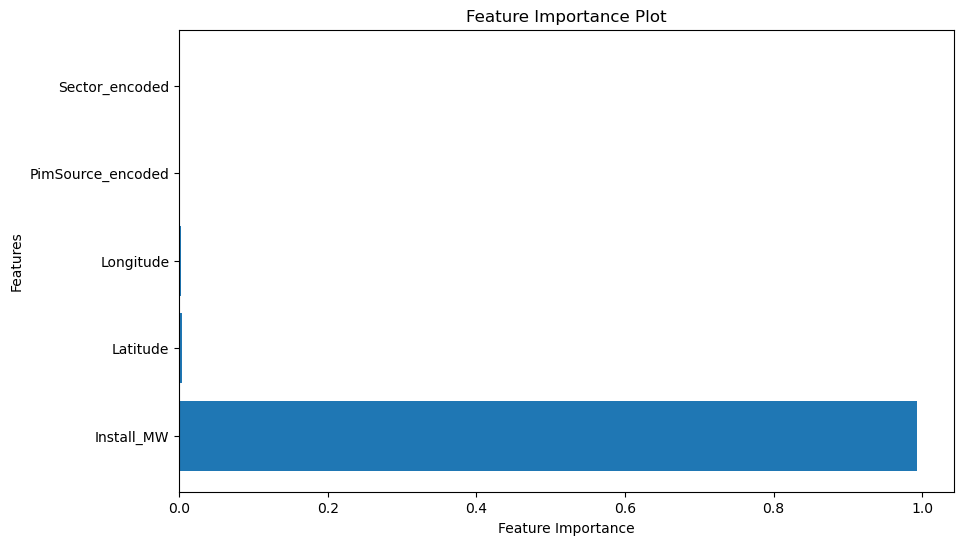

In [81]:
import matplotlib.pyplot as plt

# Get feature importances from the trained model
feature_importances = random_forest.feature_importances_

# Get feature names from the dataset
feature_names = X.columns

# Sort feature importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_indices)), feature_importances[sorted_indices], align='center')
plt.yticks(range(len(sorted_indices)), feature_names[sorted_indices])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance Plot')
plt.show()


In [84]:
from pdpbox import pdp, get_dataset, info_plots

# Create partial dependence plots
pdp_goals = pdp.pdp_isolate(model=random_forest, dataset=X_train, model_features=X_train.columns, feature=['Feature1', 'Feature2'])
pdp.pdp_plot(pdp_goals, 'Feature1 & Feature2')
plt.show()


ModuleNotFoundError: No module named 'pdpbox'

### Permutation Importance

In [ ]:
X

In [ ]:
from sklearn.inspection import permutation_importance

# Compute permutation importance
perm_importance = permutation_importance(rf, X_test, y_test)
sorted_indices = np.argsort(perm_importance.importances_mean)[::-1]

# Plot permutation importance
plt.figure(figsize=(10, 12))
plt.barh(range(len(sorted_indices)), perm_importance.importances_mean[sorted_indices], align='center')
plt.yticks(range(len(sorted_indices)), X.columns[sorted_indices])
plt.xlabel('Permutation Importance')
plt.ylabel('Features')
plt.title('Permutation Importance Plot')
plt.show()


### Partial Dependence Plots

In [ ]:
python.exe -m pip install --upgrade pip


In [ ]:
import shap

# Calculate SHAP values
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)


# KNN

In [86]:
from sklearn.neighbors import KNeighborsRegressor

knn_regressor = KNeighborsRegressor(n_neighbors=5)  # You can adjust the number of neighbors (K) as needed

# Train the model
knn_regressor.fit(X_train, y_train)

# Make predictions
y_pred = knn_regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


Mean Squared Error: 3681.213105245629


In [89]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Assuming you have your features in X and target variable in y

# Initialize the SVM regressor
svm_regressor = SVR(kernel='poly')  # You can specify different kernels like 'linear', 'poly', 'sigmoid', etc.

# Train the model
svm_regressor.fit(X_train, y_train)

# Make predictions
y_pred = svm_regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


Mean Squared Error: 18880.64736405939


# Pytorch

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# Convert features and target variable to PyTorch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y_encoded, dtype=torch.long)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Create data loaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
# Check the shapes
print("Shape of features (X_tensor):", X_tensor.shape)
print("Shape of target variable (y_tensor):", y_tensor.shape)

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# Assuming X_tensor and y_tensor are your torch tensors

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Define the model architecture
class Model(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return self.softmax(x)

# Initialize the model
input_size = X_train.shape[1]
num_classes = len(np.unique(y_train))
model = Model(input_size, num_classes)

# Define hyperparameters
learning_rate = 0.001
num_epochs = 20
batch_size = 128

# Define loss function
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Create DataLoader for training
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Training loop
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

# Evaluation
with torch.no_grad():
    outputs = model(X_test)
    _, predicted = torch.max(outputs, 1)
    accuracy = accuracy_score(y_test.numpy(), predicted.numpy())
    print(f'Accuracy on test set: {accuracy:.2f}')


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# Assuming X_tensor and y_tensor are your torch tensors

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Define the model architecture
class Model(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return self.softmax(x)

# Initialize the model
input_size = X_train.shape[1]
num_classes = len(np.unique(y_train))
model = Model(input_size, num_classes)

# Define hyperparameters
learning_rate = 0.001
num_epochs = 20
batch_size = 128

# Define loss function
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Create DataLoader for training
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Training loop
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

# Evaluation
with torch.no_grad():
    outputs = model(X_test)
    _, predicted = torch.max(outputs, 1)
    accuracy = accuracy_score(y_test.numpy(), predicted.numpy())
    print(f'Accuracy on test set: {accuracy:.2f}')
